# Aquifer Characterization Using Temperature Response

## Learning Objectives
- Understand how temperature can be used as a natural tracer for aquifer characterization
- Learn inverse modeling techniques for estimating aquifer properties
- Apply gamma distribution models to represent aquifer heterogeneity
- Interpret thermal breakthrough curves in hydrogeological contexts

## Overview

This notebook demonstrates inverse modeling to estimate aquifer pore volume distribution from temperature breakthrough curves. Temperature acts as a conservative tracer with known thermal retardation, allowing characterization of flow paths and residence times.

### Applications
- Groundwater vulnerability assessment
- Residence time distribution analysis
- Contaminant transport forecasting
- Aquifer heterogeneity characterization

### Key Assumptions
- Stationary pore volume distribution
- Advection-dominated transport (Péclet number >> 1)
- Thermal retardation factor = 2.0 (typical for saturated media)
- Conservative tracer behavior for temperature

## Theoretical Background

### Thermal Transport in Groundwater

Heat transport in groundwater systems is governed by:
- **Advection**: Heat carried by flowing water
- **Thermal retardation**: Heat exchange with solid matrix slows thermal front
- **Dispersion**: Mechanical and thermal dispersion (often negligible for large-scale transport)

### Mathematical Model

The residence time distribution for thermal transport is related to the aquifer pore volume distribution through:

$$t_{residence} = \frac{V_{pore} \cdot R_f}{Q}$$

Where:
- $V_{pore}$: Pore volume [m³]
- $R_f$: Thermal retardation factor [-] 
- $Q$: Flow rate [m³/day]

### Gamma Distribution Model

Aquifer heterogeneity is represented using a gamma distribution for pore volumes, characterized by shape (α) and scale (β) parameters.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import gamma as gamma_dist

from gwtransport import advection
from gwtransport import gamma as gamma_utils
from gwtransport.examples import generate_example_data

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Synthetic Data Generation

We generate realistic temperature and flow time series to demonstrate the inverse modeling approach. The synthetic data includes seasonal patterns and realistic variability.

In [2]:
# Generate 6 years of daily data with seasonal patterns
df, tedges = generate_example_data(
    date_start="2020-01-01",
    date_end="2025-05-31",
    flow_mean=120.0,  # Base flow rate [m³/day]
    flow_amplitude=40.0,  # Seasonal flow variation [m³/day]
    flow_noise=5.0,  # Random daily fluctuations [m³/day]
    temp_infiltration_method="soil_temperature",  # Use real soil temperature data
    aquifer_pore_volume_gamma_mean=8000.0,  # True mean pore volume [m³]
    aquifer_pore_volume_gamma_std=400.0,  # True standard deviation [m³]
    retardation_factor=2.0,  # Thermal retardation factor [-]
    temp_measurement_noise=0.1,  # Measurement noise for temperatures. Set to zero for perfect fit.[°C]
)

print("Dataset Summary:")
print(f"Period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Mean flow: {df['flow'].mean():.1f} m³/day")
print(f"Mean infiltration temperature: {df['temp_infiltration'].mean():.1f} °C")
print(f"Mean extraction temperature: {df['temp_extraction'].mean():.1f} °C")
print(f"True mean pore volume: {df.attrs['aquifer_pore_volume_gamma_mean']:.1f} m³")
print(f"True std deviation: {df.attrs['aquifer_pore_volume_gamma_std']:.1f} m³")

Dataset Summary:
Period: 2020-01-01 to 2025-05-31
Mean flow: 105.2 m³/day
Mean infiltration temperature: 11.8 °C
Mean extraction temperature: 12.0 °C
True mean pore volume: 8000.0 m³
True std deviation: 400.0 m³


## 2. Parameter Estimation via Optimization

We implement inverse modeling to estimate gamma distribution parameters using nonlinear least squares optimization. A spin-up period is excluded to allow thermal breakthrough to stabilize. Use gwtransport.residence_time.fraction_explained to compute the exact duration of the spin up period.

In [3]:
# Define training dataset (exclude first year for thermal equilibration)
train_data = df["2021-01-01":].temp_extraction
train_data = train_data.dropna()
train_length = len(train_data)

print(f"Training dataset: {train_length} days")
print(f"Training period: {train_data.index[0].date()} to {train_data.index[-1].date()}")

Training dataset: 1612 days
Training period: 2021-01-01 to 2025-05-31


In [4]:
def objective(_xdata, mean, std):
    """Infiltration to extraction model for temperature breakthrough with gamma-distributed pore volumes."""
    print(f"Optimizing: mean={mean:.1f} m³, std={std:.1f} m³")

    cout = advection.gamma_infiltration_to_extraction(
        cin=df.temp_infiltration,
        flow=df.flow,
        tedges=tedges,
        cout_tedges=tedges,
        mean=mean,  # Mean pore volume [m³]
        std=std,  # Standard deviation [m³]
        n_bins=25,  # Discretization resolution
        retardation_factor=2.0,  # Thermal retardation factor
    )

    # Return training period data
    return cout[df.index >= "2021-01-01"]

In [5]:
# Nonlinear least squares optimization
print("Starting parameter optimization...")

(mean, std), pcov = curve_fit(
    objective,
    df.index,
    train_data.values,
    p0=(7500.0, 450.0),  # Initial parameter estimates [m³]
    bounds=([5000, 200], [10000, 600]),  # Physical constraints [m³]
    method="trf",  # Trust Region Reflective algorithm
    max_nfev=250,  # Limit function evaluations
)

print("\nOptimization completed!")

Starting parameter optimization...
Optimizing: mean=7500.0 m³, std=450.0 m³
Optimizing: mean=7500.0 m³, std=450.0 m³
Optimizing: mean=7500.0 m³, std=450.0 m³
Optimizing: mean=7696.9 m³, std=457.8 m³
Optimizing: mean=7696.9 m³, std=457.8 m³
Optimizing: mean=7696.9 m³, std=457.8 m³
Optimizing: mean=7838.0 m³, std=471.2 m³
Optimizing: mean=7838.0 m³, std=471.2 m³
Optimizing: mean=7838.0 m³, std=471.2 m³
Optimizing: mean=7920.4 m³, std=458.4 m³
Optimizing: mean=7920.4 m³, std=458.4 m³
Optimizing: mean=7920.4 m³, std=458.4 m³
Optimizing: mean=7958.3 m³, std=447.9 m³
Optimizing: mean=7958.3 m³, std=447.9 m³
Optimizing: mean=7958.3 m³, std=447.9 m³
Optimizing: mean=7982.0 m³, std=437.4 m³
Optimizing: mean=7982.0 m³, std=437.4 m³
Optimizing: mean=7982.0 m³, std=437.4 m³
Optimizing: mean=7989.9 m³, std=429.3 m³
Optimizing: mean=7989.9 m³, std=429.3 m³
Optimizing: mean=7989.9 m³, std=429.3 m³
Optimizing: mean=7994.0 m³, std=421.8 m³
Optimizing: mean=7994.0 m³, std=421.8 m³
Optimizing: mean=7994.

In [6]:
# Generate model predictions using optimized parameters
df["temp_extraction_modeled"] = advection.gamma_infiltration_to_extraction(
    cin=df.temp_infiltration,
    flow=df.flow,
    tedges=tedges,
    cout_tedges=tedges,
    mean=mean,  # Fitted mean pore volume
    std=std,  # Fitted standard deviation
    n_bins=250,  # High computational resolution
    retardation_factor=2.0,  # Thermal retardation
)

# Report optimization results with uncertainty estimates
print("Parameter Estimation Results:")
print(f"Mean pore volume: {mean:.1f} ± {pcov[0, 0] ** 0.5:.1f} m³")
print(f"Standard deviation: {std:.1f} ± {pcov[1, 1] ** 0.5:.1f} m³")
print(f"Coefficient of variation: {std / mean:.2f}")

# Compare with true values
true_mean = df.attrs["aquifer_pore_volume_gamma_mean"]
true_std = df.attrs["aquifer_pore_volume_gamma_std"]
print(f"\nTrue values: {true_mean:.1f} m³ (mean), {true_std:.1f} m³ (std)")
print(
    f"Relative error: {abs(mean - true_mean) / true_mean * 100:.1f}% (mean), {abs(std - true_std) / true_std * 100:.1f}% (std)"
)

Parameter Estimation Results:
Mean pore volume: 7997.7 ± 0.9 m³
Standard deviation: 401.6 ± 1.1 m³
Coefficient of variation: 0.05

True values: 8000.0 m³ (mean), 400.0 m³ (std)
Relative error: 0.0% (mean), 0.4% (std)


## 3. Model Validation and Visualization

We compare observed and modeled temperature breakthrough curves to assess model performance.

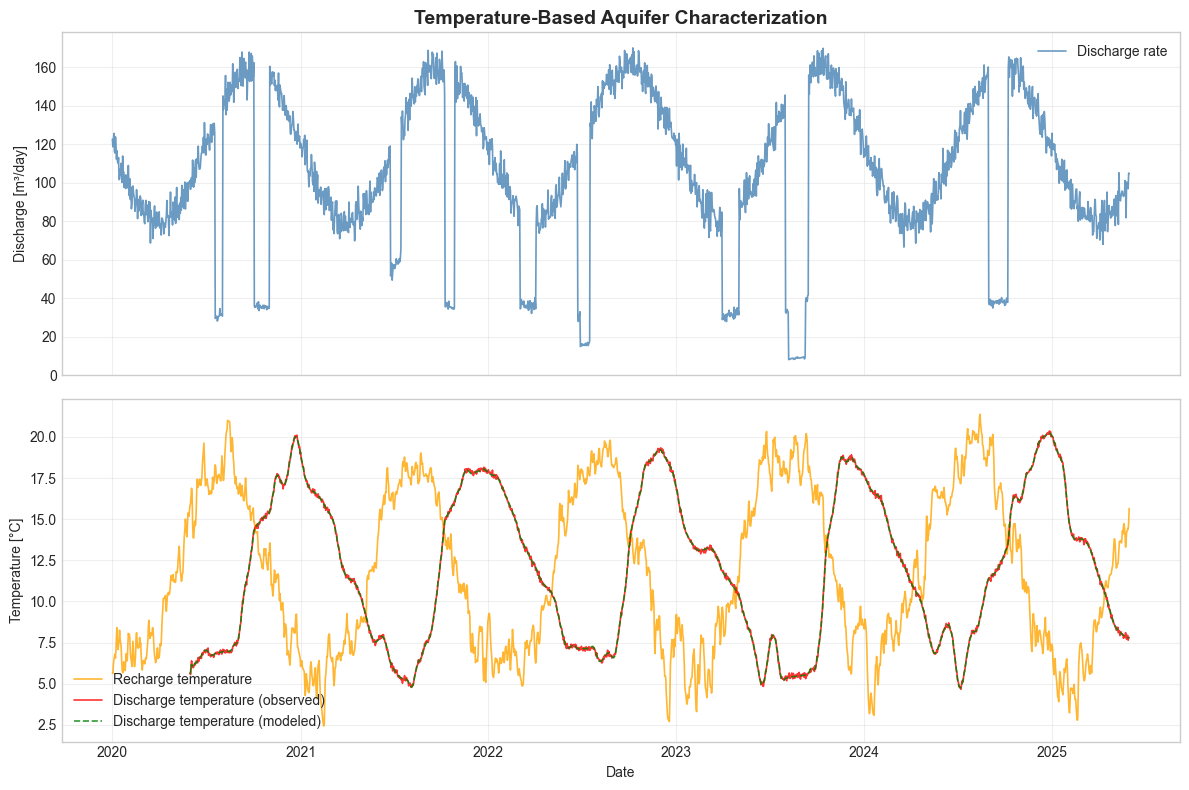

Temperature response plot saved to: 01_Temperature_response.png


In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 8), nrows=2, ncols=1, sharex=True)

# Flow rate subplot
ax1.set_title("Temperature-Based Aquifer Characterization", fontsize=14, fontweight="bold")
ax1.plot(df.index, df.flow, label="Discharge rate", color="steelblue", alpha=0.8, linewidth=1.2)
ax1.set_ylabel("Discharge [m³/day]")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Temperature subplot
ax2.plot(df.index, df.temp_infiltration, label="Recharge temperature", color="orange", alpha=0.8, linewidth=1.2)
ax2.plot(df.index, df.temp_extraction, label="Discharge temperature (observed)", color="red", alpha=0.8, linewidth=1.2)
ax2.plot(
    df.index,
    df.temp_extraction_modeled,
    label="Discharge temperature (modeled)",
    color="green",
    alpha=0.8,
    linewidth=1.2,
    linestyle="--",
)

ax2.set_xlabel("Date")
ax2.set_ylabel("Temperature [°C]")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save the temperature response plot
out_path = Path("01_Temperature_response.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Temperature response plot saved to: {out_path}")

## 4. Pore Volume Distribution Analysis

We visualize the fitted gamma distribution representing spatial heterogeneity in pore volume. Each bin represents a different flow path through the aquifer.

In [8]:
# Discretize gamma distribution into flow path bins
n_bins = 10  # Reduced for visualization clarity
alpha, beta = gamma_utils.mean_std_to_alpha_beta(mean=mean, std=std)
gbins = gamma_utils.bins(alpha=alpha, beta=beta, n_bins=n_bins)

print(f"Gamma Distribution Parameters: alpha={alpha:.1f}, beta={beta:.1f}")
print(f"Discretized into {n_bins} equiprobable bins:")
print("-" * 80)
print(f"{'Bin':3s} {'Lower [m³]':10s} {'Upper [m³]':10s} {'E[V|bin]':10s} {'P(bin)':10s}")
print("-" * 80)

for i in range(n_bins):
    upper = f"{gbins['upper_bound'][i]:.1f}" if not np.isinf(gbins["upper_bound"][i]) else "∞"
    lower = f"{gbins['lower_bound'][i]:.1f}"
    expected = f"{gbins['expected_values'][i]:.1f}"
    prob = f"{gbins['probability_mass'][i]:.3f}"
    print(f"{i:3d} {lower:10s} {upper:10s} {expected:10s} {prob:10s}")

Gamma Distribution Parameters: alpha=396.7, beta=20.2
Discretized into 10 equiprobable bins:
--------------------------------------------------------------------------------
Bin Lower [m³] Upper [m³] E[V|bin]   P(bin)    
--------------------------------------------------------------------------------
  0 0.0        7487.6     7308.2     0.100     
  1 7487.6     7657.9     7579.1     0.100     
  2 7657.9     7782.3     7722.2     0.100     
  3 7782.3     7889.7     7836.9     0.100     
  4 7889.7     7990.9     7940.5     0.100     
  5 7990.9     8093.1     8041.7     0.100     
  6 8093.1     8203.3     8147.1     0.100     
  7 8203.3     8333.5     8265.9     0.100     
  8 8333.5     8516.4     8417.7     0.100     
  9 8516.4     ∞          8717.3     0.100     


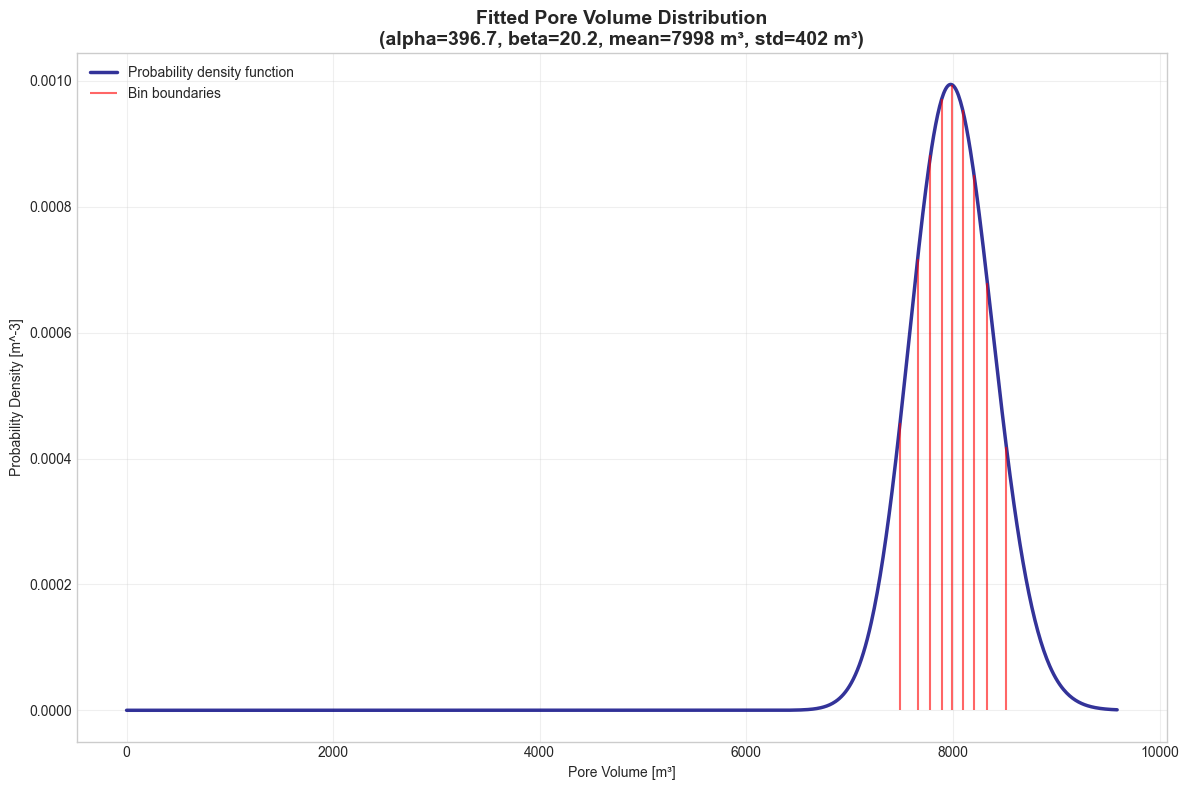

Pore volume distribution plot saved to: 01_Pore_volume_distribution.png


In [9]:
# Plot the gamma distribution and bins
x = np.linspace(0, 1.1 * gbins["expected_values"][-1], 1000)
y = gamma_dist.pdf(x, alpha, scale=beta)

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title(
    f"Fitted Pore Volume Distribution\n(alpha={alpha:.1f}, beta={beta:.1f}, mean={mean:.0f} m³, std={std:.0f} m³)",
    fontsize=14,
    fontweight="bold",
)

ax.plot(x, y, label="Probability density function", color="navy", alpha=0.8, linewidth=2.5)
pdf_at_lower_bound = gamma_dist.pdf(gbins["lower_bound"], alpha, scale=beta)
ax.vlines(
    gbins["lower_bound"],
    0,
    pdf_at_lower_bound,
    color="red",
    alpha=0.6,
    linewidth=1.5,
    label="Bin boundaries",
)

ax.set_xlabel("Pore Volume [m³]")
ax.set_ylabel("Probability Density [m^-3]")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the pore volume distribution plot
out_path = Path("01_Pore_volume_distribution.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Pore volume distribution plot saved to: {out_path}")

## Results & Discussion

### Model Performance
The inverse modeling successfully recovered the aquifer pore volume distribution parameters with good accuracy. The fitted gamma distribution captures the heterogeneity in flow paths through the aquifer.

### Engineering Insights
1. **Thermal Retardation**: The factor of 2.0 represents heat exchange between groundwater and the solid matrix
2. **Flow Path Variability**: The gamma distribution shows that some water follows fast paths while other water has much longer residence times
3. **Seasonal Effects**: Flow rate variations cause seasonal changes in residence time distributions

### Practical Applications
- **Contaminant Transport**: Use fitted parameters to predict pollutant breakthrough
- **Well Field Design**: Optimize extraction rates based on residence time requirements
- **Vulnerability Assessment**: Identify fast flow paths that may compromise water quality

## Key Takeaways

✅ **Temperature as Natural Tracer**: Temperature provides valuable information about aquifer properties without artificial injection

✅ **Inverse Modeling**: Optimization techniques can extract quantitative aquifer parameters from field observations

✅ **Gamma Distribution**: Effective model for representing aquifer heterogeneity in engineering applications

✅ **Thermal Retardation**: Must account for heat exchange when using temperature data

✅ **Spin-up Period**: Allow sufficient time for thermal equilibration before parameter estimation